# Packages

In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import date, datetime
from metaspace import SMInstance
import scanpy as sc
from PIL import Image, ImageFilter
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import utils
from coloc_utils import *
from config import store_dir, data_dir, date_key, enrichment_dir, module_dir, figuredata_dir
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/linex2/parser.py:22: RuntimeWarning: Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.
  warnings.warn(


# Load data

Requires all previous case study notebooks/scripts to be executed before. Their output data is required to assemble the main figure.

In [3]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [4]:
# All dataset IDs are not public and therefore not available on GitHub
# Comment out the whole cell if table is not available
all_ds_ids = pd.read_csv(os.path.join(data_dir, 'all_dataset_ids-2024-04-04.csv'))
all_ds_ids['dataset_id'] = all_ds_ids['dataset_id'].apply(lambda x: toYearFraction(date.fromisoformat(x.split('_')[0])))
all_ds_ids['Datasets'] = 'All'
all_ds_ids = all_ds_ids.rename(columns={'dataset_id':'Date'})
all_ds_ids = all_ds_ids.sort_values('Date')
all_ds_ids['Submissions'] = np.arange(all_ds_ids.shape[0])

sm = SMInstance()
new_datasets = sm.datasets()

public_ids = pd.DataFrame({'Date': [toYearFraction(date.fromisoformat(x.id.split('_')[0])) for x in new_datasets]})
public_ids = public_ids[public_ids['Date'] <= all_ds_ids['Date'].max()]
public_ids['Datasets'] = 'Public'
public_ids = public_ids.sort_values('Date')
public_ids['Submissions'] = np.arange(public_ids.shape[0])

In [5]:
adata_marker_pos = pickle.load(open(os.path.join(figuredata_dir, 'marker_pos_adata.pickle'), "rb" ) )
pos_marker = pickle.load(open(os.path.join(figuredata_dir, 'marker_pos.pickle'), "rb" ) )
mapping_dict = pickle.load(open(os.path.join(figuredata_dir, 'marker_pos_mapping.pickle'), "rb" ) )
adata_marker_neg = pickle.load(open(os.path.join(figuredata_dir, 'marker_neg_adata.pickle'), "rb" ) )
neg_marker = pickle.load(open(os.path.join(figuredata_dir, 'marker_neg.pickle'), "rb" ) )
mapping_dict2 = pickle.load(open(os.path.join(figuredata_dir, 'marker_neg_mapping.pickle'), "rb" ) )

organ_colors = pickle.load(open(os.path.join(store_dir, 'organ_colors.pickle'), "rb" ) )

In [6]:
def marker_heatmap(adata, marker, ax):
    df =  pd.DataFrame(adata.X, columns=adata.var.index, index=adata.obs.index)
    df = df[marker]
    df = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df), index=df.index, columns=df.columns).reset_index()
    df = pd.melt(df, id_vars='index').set_index('index')
    df = df.join(adata.obs[['top_Organism_Part']]).reset_index(drop=True)
    df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
    df = df.pivot(columns='molecule', index='top_Organism_Part')
    df.columns = df.columns.droplevel(0)
    sns.heatmap(df, cmap='RdBu_r', center=0, ax=ax)  # , cbar_kws={'label': 'z-score'}

In [7]:
adcbbknn = pickle.load(open(os.path.join(store_dir, 'single_pixel_adata_Brain_bbknn.pickle'), "rb"))
adcbbknn = adcbbknn[adcbbknn.obs['ds']!='2017-06-09_07h12m31s', :]

In [8]:
lclusters = sorted(list(set(adcbbknn.obs['leiden'])))
a = plt.get_cmap('Pastel1', 9)([np.arange(9)])[0]
b = plt.get_cmap('Pastel2', 10)([np.arange(10)])[0]
c = plt.get_cmap('Set3', 10)([np.arange(10)])[0]
comb = np.concatenate((a,b,c))
leiden_colors = {lclusters[x]: comb[x] for x in range(len(lclusters))}
leiden_colors['7'] = "#1187ee"

In [9]:
def umap_df(adata, features=None):
    if features is None:
        return adata.obs.reset_index().join(pd.DataFrame(adata.obsm['X_umap']).rename(columns={0: 'umap_x', 1: 'umap_y'}))
    else:
        df = adata.obs.reset_index().join(pd.DataFrame(adata.obsm['X_umap']).rename(columns={0: 'umap_x', 1: 'umap_y'}))
        for feature in features:
            loc = np.where(ao.var.index==feature)[0][0]
            df[feature] = adata.X[:, loc]
        return df

In [10]:
def image_outline(dsid, adata=adcbbknn):
    dummy_image = np.zeros(image_l[dsid].shape)
    tmp = adata.obs
    tmp = tmp[tmp['ds']==dsid]
    for x,y in zip(tmp['x'], tmp['y']):
        dummy_image[y, x]=1

    dummy_image = ndimage.median_filter(dummy_image, size=(3,3))
    pil_image = Image.fromarray(dummy_image.astype('uint8'))

    # Apply the FIND_EDGES filter to highlight edges
    edge_image = pil_image.filter(ImageFilter.FIND_EDGES)

    # Convert the result back to a NumPy array
    edge_array = np.array(edge_image)

    return edge_array

In [11]:
tmp = adcbbknn.obs[adcbbknn.obs['leiden']=='7']
tmp = min_pixels(tmp, min_pixels=100)
tmp['ds'] = tmp['ds'].astype(str)
dsl = set(tmp['ds'])
sm = metaspace.SMInstance()

sc.tl.rank_genes_groups(adcbbknn, groupby='leiden', method='t-test')
tmp = sc.get.rank_genes_groups_df(adcbbknn, '7')
mol = tmp['names'][0]

image_l = {}
for dsid in dsl:
    ds = sm.dataset(id=dsid)
    image_l[dsid] = ds.isotope_images(mol, '+H')[0]

/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  ut

In [12]:
lxpv = pickle.load(open(os.path.join(figuredata_dir, 'biochemistry.pickle'), "rb" ) )
lxpv_rand = pickle.load(open(os.path.join(figuredata_dir, 'biochemistry_random.pickle'), "rb" ) )

In [13]:
def plot_biochemistry(ax, lxpv, lxpv_rand, ly=.98, ty=.97, order=None):
    
    lxpv['significant'] = lxpv["-log10(p)"]>-np.log10(0.05)

    lxpv['diff'] = lxpv['bioch_coloc'] - lxpv['other_coloc']
    lxpv['type'] = 'Data'
    lxpv_rand['type'] = 'Baseline'
    lxpv_combined = pd.concat([lxpv.drop(columns=['-log10(p)', 'significant']).reset_index(), lxpv_rand.reset_index()]).drop(columns=['index']).reset_index(drop=True)

    # sns.violinplot(data=lxpv_combined, x='type', y='diff', ax=ax2, palette={'Data': '#18974C', 'Baseline': '#734595'})
    if order is not None:
        sns.violinplot(data=lxpv_combined, x='tissue', y='diff', hue='type', ax=ax, palette={'Data': '#1187ee', 'Baseline': 'white'}, cut=0, inner=None, order=order)
    else:
        sns.violinplot(data=lxpv_combined, x='tissue', y='diff', hue='type', ax=ax, palette={'Data': '#1187ee', 'Baseline': 'white'}, cut=0, inner=None) # , linewidth=.5
    ax.axline((0,0), (1,0), color='black', linestyle='-', linewidth=.6)
    # ax2.axline((0, pctl[0]), (1, pctl[0]), color='grey', linestyle='--', linewidth=.5)
    # ax2.axline((0, pctl[1]), (1, pctl[1]), color='grey', linestyle='--', linewidth=.5)

    # Significance annotations
    for pos, xtick in enumerate(ax.get_xticklabels()):
        tis_label = xtick.get_text()

        test_data = lxpv_combined.loc[(lxpv_combined['type'] == 'Data') & (lxpv_combined['tissue'] == tis_label), 'diff']
        test_baseline = lxpv_combined.loc[(lxpv_combined['type'] == 'Baseline') & (lxpv_combined['tissue'] == tis_label), 'diff']

        # P-value for difference with multiple testing correction
        testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * len(ax.get_xticklabels())

        sigind = 'n.s.'
        sigind = '*' if testres <= 0.05 else sigind
        sigind = '**' if testres <= 0.01 else sigind
        sigind = '***' if testres <= 0.001 else sigind

        ax.annotate('', xy=(pos-.3, ly), xytext=(pos+.3,ly), arrowprops=dict(arrowstyle='-', color='black'))
        ax.annotate(sigind, xy=(pos, ty), ha='center', fontsize=7)

    ax.set_xlabel('')
    ax.set_ylabel('Biohemical to non-biochemical\ncolocalization difference')
    ax.set_ylim((-0.8, 1.1))
    sns.despine(offset=5, trim=False, ax=ax)
    ticks = ax.get_xticklabels()
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ticks, rotation = 30, ha='right')
    sns.move_legend(ax, "lower right", title='')

In [14]:
def replace_epididymis_axl(ax):
    tks = ax.get_xticklabels()
    for tk in tks:
        tmp = tk.get_text()
        tt = tmp if tmp != 'Epididymis' else 'Testis'
        tk.set_text(tt)
    ax.set_xticklabels(tks, rotation = 30, ha='right')

In [15]:
selected_visualizations = [
    ('Brain', '2022-01-31_09h08m54s', 'C41H83N2O6P', '+K', []),
    ('Lung', '2020-12-22_23h04m28s', 'C40H78NO8P', '+Na', []),
    ('Kidney', '2021-01-22_21h03m20s', 'C42H80NO8P', '+K', []),
    ('Root', '2022-04-16_01h14m55s', 'C12H22O11', '+K', [])
]

sm = SMInstance()

for i in range(len(selected_visualizations)):
    ds = sm.dataset(id=selected_visualizations[i][1])
    images = ds.isotope_images(selected_visualizations[i][2], selected_visualizations[i][3])
    image = images[0]
    # Hotspot clipping
    hotspot = np.percentile(image, 99)
    image[image > hotspot] = hotspot
    selected_visualizations[i] = (selected_visualizations[i][0], selected_visualizations[i][1], selected_visualizations[i][2], selected_visualizations[i][3], image)

In [16]:
def plot_ionimage(selected_visualizations, ax, i, fig, mapping_dict, yoffset=1.):
    image = selected_visualizations[i][4]
    im = ax.imshow(image)
    ax.axis('off')
    image_colorbar(ax, fig, im, size="5%", pad=0.1, shrink=0.6, location='bottom')
    
    title_x_position = (ax.get_position().x1 - ax.get_position().x0)/2 + ax.get_position().x0
        
    ionfig.text(title_x_position, yoffset, '{} ({})'.format(mapping_dict[selected_visualizations[i][2]], selected_visualizations[i][0]), fontsize=SMALL_SIZE, horizontalalignment='center')

In [17]:
def ax_ann(fig, ax, letter='A', xoffset=0, yoffset=0, **kwargs):

    axes_position = ax.get_position()
    # Extract position and size information
    left, bottom, width, height = axes_position.bounds
    
    fig.text(left+xoffset, bottom+height+yoffset, letter, **kwargs)
    
def draw_umapaxis(ax, length_mul=.1, yoffset=0.):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    deltax = xlims[1] - xlims[0]
    deltay = ylims[1] - ylims[0]
    
    # X-Annotation
    ax.annotate('', xy=(xlims[0]+length_mul*deltax, ylims[0]+yoffset), xytext=(xlims[0], ylims[0]+yoffset), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP1', (xlims[0]+length_mul*deltax, ylims[0]+yoffset), ha='left', va='center', fontsize=XSMALL_SIZE)
    
    ax.annotate('', xy=(xlims[0], ylims[0]+length_mul*deltay+yoffset), xytext=(xlims[0], ylims[0]+yoffset), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP2', (xlims[0], ylims[0]+length_mul*deltay+yoffset), ha='center', va='bottom', fontsize=XSMALL_SIZE)

def increase_legend_patchsize(ax, size=.5, **kwargs):
    leg = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    patches=[]
    for handle, label in zip(handles, labels):
        patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=size, marker='o', linestyle=''))
    legend = ax.legend(handles=patches, **kwargs)

# Main Figure assembly

Some plots (e.g. from R) are left blank and are inserted manually later using Inkscape.

In [18]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/tmp/ipykernel_607/152682660.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
/tmp/ipykernel_607/152682660.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


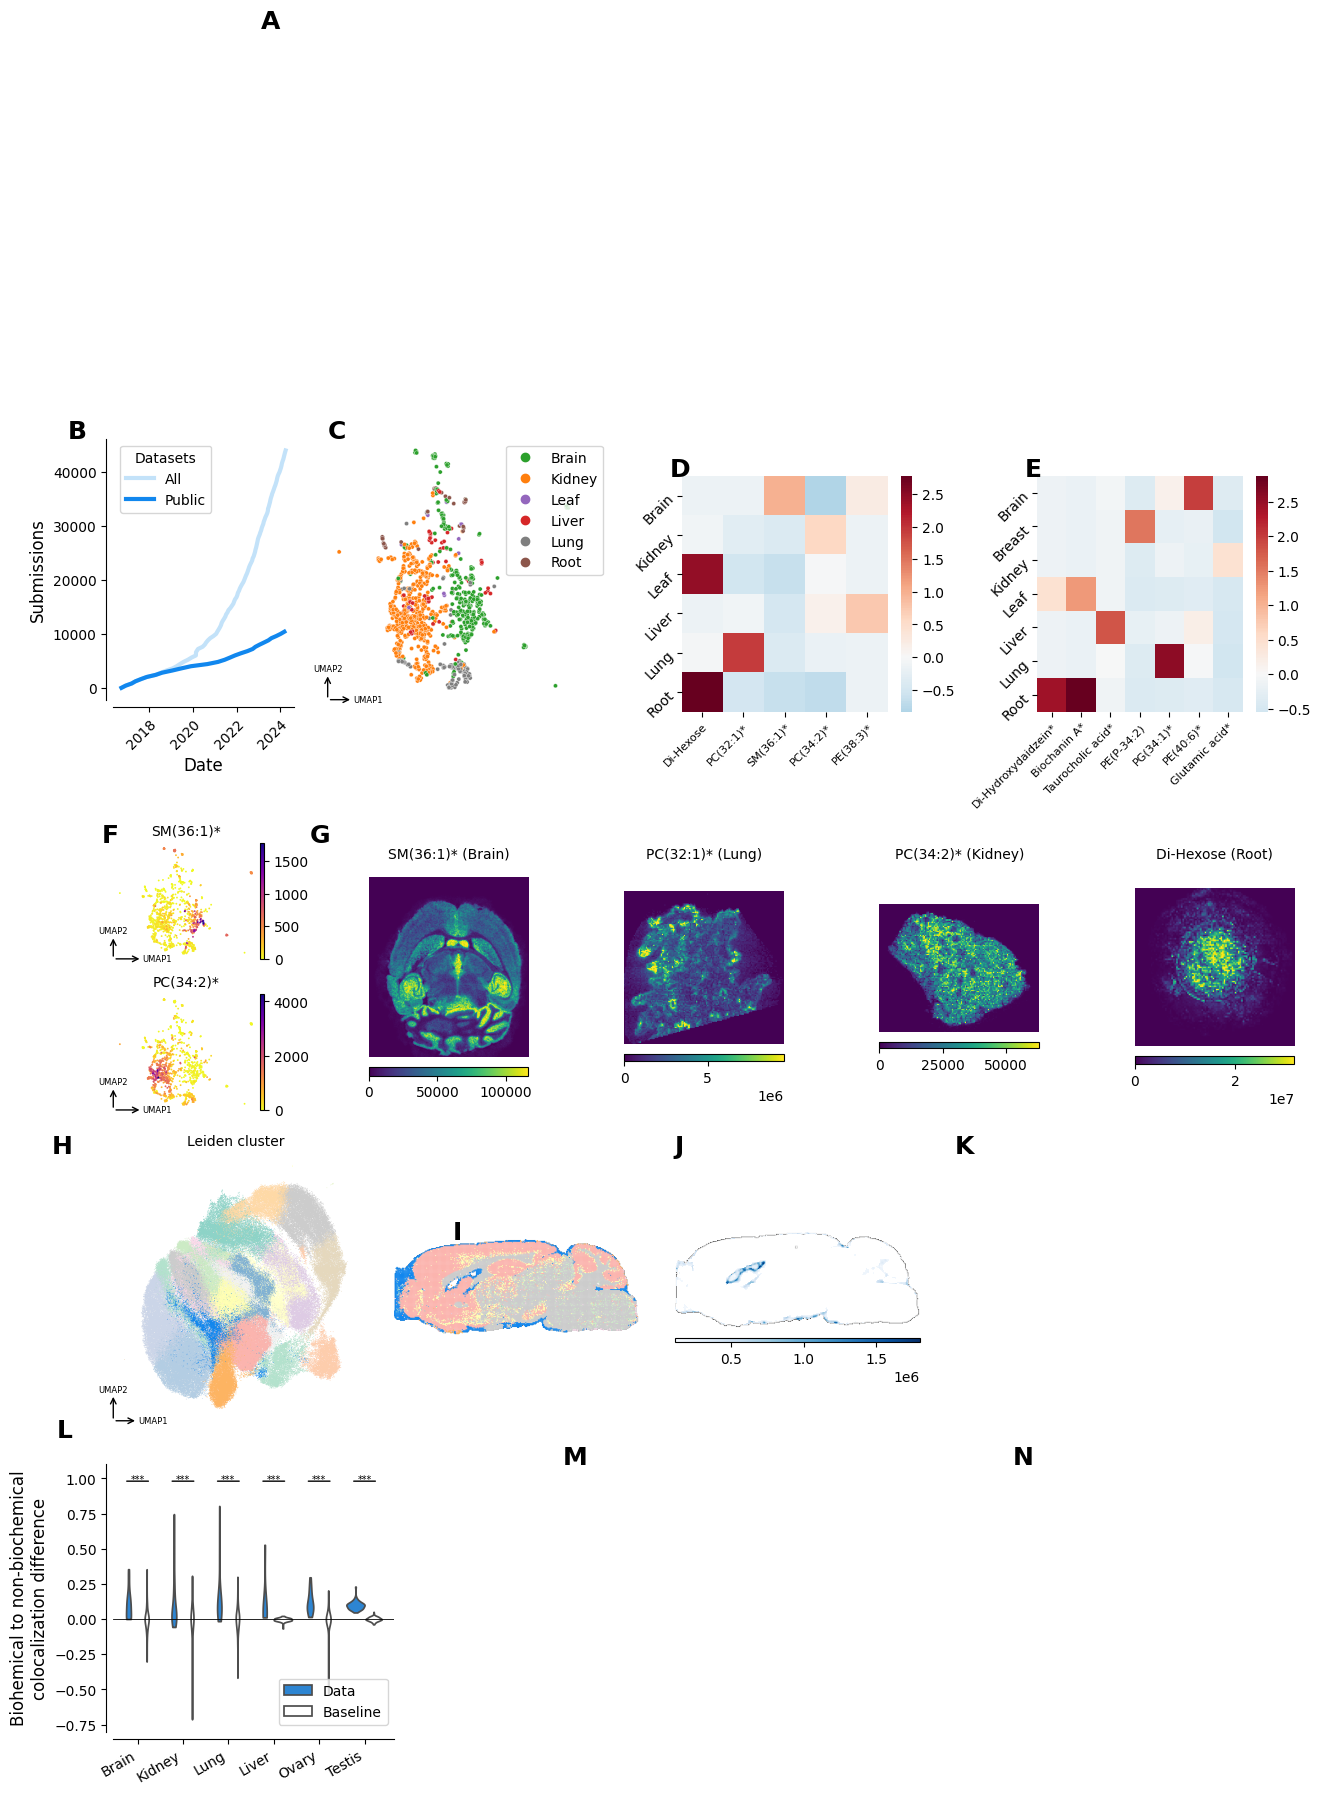

In [23]:
fig = plt.figure(figsize=(30*cm, 45*cm))

(topfig, markerfig, ionfig, brainfig, colocfig) = fig.subfigures(5, 1, height_ratios=[1.5, 1.2, 1., 1., 1.])

# ####
# Top part
# ####

# topfig.subplots_adjust(left=.0, right=1., bottom=0.04, top=1., hspace=.3)

top_ax = topfig.subplots(1)

top_ax.axis('off')
ax_ann(topfig, top_ax, letter='A', size=BIGGER_SIZE, weight='bold')

# ####
# Figure structure
# ####

markerfig.subplots_adjust(left=.0, right=1., bottom=0.3, top=1., hspace=.3, wspace=.9)
gs_marker = plt.GridSpec(nrows=4, ncols=3+4+4+4+2)
ax_subm = markerfig.add_subplot(gs_marker[0:4, 0:3])
ax_umap = markerfig.add_subplot(gs_marker[0:4, 3:7])
ax_mrkp = markerfig.add_subplot(gs_marker[0:3, 8:12])
ax_mrkn = markerfig.add_subplot(gs_marker[0:3, 13:17])

ionfig.subplots_adjust(left=.0, right=1., bottom=0.04, top=.9, wspace=.6)
gs_ion = plt.GridSpec(nrows=2, ncols=5)
ax_ump1 = ionfig.add_subplot(gs_ion[0, 0])
ax_ump2 = ionfig.add_subplot(gs_ion[1, 0])
ax_iim1 = ionfig.add_subplot(gs_ion[0:2, 1])
ax_iim2 = ionfig.add_subplot(gs_ion[0:2, 2])
ax_iim3 = ionfig.add_subplot(gs_ion[0:2, 3])
ax_iim4 = ionfig.add_subplot(gs_ion[0:2, 4])


brainfig.subplots_adjust(left=.0, right=1., bottom=0.04, top=.9, wspace=.6)
gs_brain = plt.GridSpec(nrows=2, ncols=3+3+3+4)
ax_bldn = brainfig.add_subplot(gs_brain[0:2, 0:3])
ax_brsg = brainfig.add_subplot(gs_brain[0:2, 3:6])
ax_brii = brainfig.add_subplot(gs_brain[0:2, 6:9])
ax_ntwk = brainfig.add_subplot(gs_brain[0:2, 9:13])

colocfig.subplots_adjust(left=.0, right=1., bottom=0.04, top=.9, wspace=.6)
(ax_bchm, ax_dist, ax_corg) = colocfig.subplots(ncols=3)


# Placeholders for things pasted manually
ax_ntwk.axis('off')
ax_ntwk.text(0, 1., 'K', transform=ax_ntwk.transAxes, size=BIGGER_SIZE, weight='bold')
ax_dist.axis('off')
ax_dist.text(0, 1., 'M', transform=ax_dist.transAxes, size=BIGGER_SIZE, weight='bold')
ax_corg.axis('off')
ax_corg.text(0, 1., 'N', transform=ax_corg.transAxes, size=BIGGER_SIZE, weight='bold')

# Submissions
# Replace `pd.concat([all_ds_ids, public_ids])` with `public_ids` if private table with all dataset IDs is not available
sns.lineplot(data=pd.concat([all_ds_ids.iloc[::400, :], public_ids.iloc[::400, :]]), x='Date', y='Submissions', hue='Datasets', 
             palette={'Public': '#1187ee', 'All': '#c3e2f9ff'}, lw=3, ax=ax_subm)
sns.despine(offset=5, trim=False, ax=ax_subm)
ax_subm.set_xticks([2018, 2020, 2022, 2024])
ax_subm.set_xticklabels(ax_subm.get_xticklabels(), rotation = 45, ha="right", rotation_mode="anchor")
markerfig.text(-.25, 1., 'B', transform=ax_subm.transAxes, size=BIGGER_SIZE, weight='bold')


# UMAP positive
pos_umap = adata_marker_pos.obs.reset_index().join(pd.DataFrame(adata_marker_pos.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'})).rename(columns={'top_Organism_Part': 'Organ',})
sns.scatterplot(data=pos_umap, x='x', y='y', hue='Organ', s=9, palette=organ_colors, ax=ax_umap)
ax_umap.axis('off')
draw_umapaxis(ax_umap, yoffset=0)
increase_legend_patchsize(ax_umap, size=.2, loc='upper center', bbox_to_anchor=(.9, 1.), ncol=1)
ax_ann(markerfig, ax_umap, letter='C', size=BIGGER_SIZE, weight='bold')


# Marker positive
marker_heatmap(adata_marker_pos, pos_marker, ax=ax_mrkp)
xticks = ax_mrkp.get_xticklabels()
for mol in xticks:
    m = mol.get_text()
    if m in mapping_dict.keys():
        mol.set_text(mapping_dict[m])
ax_mrkp.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=SMALLSMALL_SIZE)
ax_mrkp.set_yticklabels(ax_mrkp.get_yticklabels(), rotation=45, ha='right', rotation_mode="anchor") 
ax_mrkp.set_ylabel('')
ax_mrkp.set_xlabel('')
ax_ann(markerfig, ax_mrkp, letter='D', size=BIGGER_SIZE, weight='bold', xoffset=-.01)


# Marker negative
marker_heatmap(adata_marker_neg, neg_marker, ax=ax_mrkn)
xticks = ax_mrkn.get_xticklabels()
for mol in xticks:
    m = mol.get_text()
    if m in mapping_dict2.keys():
        mol.set_text(mapping_dict2[m])
ax_mrkn.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=SMALLSMALL_SIZE)
ax_mrkn.set_yticklabels(ax_mrkn.get_yticklabels(), rotation=45, ha='right', rotation_mode="anchor") 
ax_mrkn.set_ylabel('')
ax_mrkn.set_xlabel('')
ax_ann(markerfig, ax_mrkn, letter='E', size=BIGGER_SIZE, weight='bold', xoffset=-.01)


# UMAP marker
ax_ump1 = sc.pl.umap(adata_marker_pos, color=pos_marker['Brain'], ax=ax_ump1, show=False, size=7, color_map="plasma_r")
ax_ump1.axis('off')
ax_ump1.set_title(mapping_dict[pos_marker['Brain']])
draw_umapaxis(ax_ump1, length_mul=.2)
ax_ann(ionfig, ax_ump1, letter='F', size=BIGGER_SIZE, weight='bold', xoffset=-.01)

ax_ump2 = sc.pl.umap(adata_marker_pos, color=pos_marker['Kidney'], ax=ax_ump2, show=False, size=7, color_map="plasma_r")
ax_ump2.axis('off')
ax_ump2.set_title(mapping_dict[pos_marker['Kidney']])
draw_umapaxis(ax_ump2, length_mul=.2)

# Ion images
plot_ionimage(selected_visualizations, ax_iim1, 0, ionfig, mapping_dict, yoffset=.85)
plot_ionimage(selected_visualizations, ax_iim2, 1, ionfig, mapping_dict, yoffset=.85)
plot_ionimage(selected_visualizations, ax_iim3, 2, ionfig, mapping_dict, yoffset=.85)
plot_ionimage(selected_visualizations, ax_iim4, 3, ionfig, mapping_dict, yoffset=.85)

ax_ann(ionfig, ax_iim1, letter='G', size=BIGGER_SIZE, weight='bold', xoffset=-.05)


# Brain leiden
brain_df = umap_df(adcbbknn)
brain_df = brain_df.sample(n=int(brain_df.shape[0]*.9))
sns.scatterplot(data=brain_df, x='umap_x', y='umap_y', hue='leiden', s=.3, ax=ax_bldn, legend=False, 
                palette=leiden_colors, linewidth = 0)
ax_bldn.axis('off')
draw_umapaxis(ax_bldn)
ax_bldn.set_title('Leiden cluster')
brainfig.text(-.25, 1., 'H', transform=ax_bldn.transAxes, size=BIGGER_SIZE, weight='bold')

# Brain segmentation
tmp = adcbbknn.obs
tmp = tmp[tmp['ds']=='2021-11-11_11h49m37s']
ax_brsg.imshow(image_outline('2021-11-11_11h49m37s'), cmap='Greys')
sns.scatterplot(data=tmp, x="x", y="y", hue='leiden', s=1., ax=ax_brsg, legend=False, palette=leiden_colors, linewidth = 0)
ax_brsg.set_aspect('equal')
ax_brsg.axis('off')
ax_ann(brainfig, ax_brsg, letter='I', size=BIGGER_SIZE, weight='bold', xoffset=0.05)
ax_brsg.invert_xaxis()

# Brain ion image
image_out = image_outline('2021-11-11_11h49m37s')
ax_brii.imshow(image_out, cmap='Greys')
tmp = ndimage.median_filter(image_l['2021-11-11_11h49m37s'], size=(3,3))
masked_img = np.ma.masked_where(tmp < 100000, tmp)
# Cbar testing
im = ax_brii.imshow(masked_img, cmap='Blues')
div = make_axes_locatable(ax_brii)
cax = div.append_axes("bottom", size="5%", pad=0.1)
cbar = brainfig.colorbar(im, cax=cax, shrink=0.6, location='bottom')
ax_brii.axis('off')
ax_brii.invert_xaxis()
ax_ann(brainfig, ax_brii, letter='J', size=BIGGER_SIZE, weight='bold')


# Biochemistry
PLOT_ORDER = ['Brain', 'Kidney', 'Lung', 'Liver', 'Ovary', 'Epididymis']
plot_biochemistry(ax_bchm, lxpv, lxpv_rand, order=PLOT_ORDER)
ax_bchm.text(-0.2, 1.1, 'L', transform=ax_bchm.transAxes, size=BIGGER_SIZE, weight='bold')
replace_epididymis_axl(ax_bchm)

plt.savefig('plots/mainFigure.pdf', bbox_inches='tight')